## Libraries and Functions 

In [1]:
import scipy.stats as stats
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import itk
import itkwidgets
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm, trange
import pickle
from glob import glob

%matplotlib inline

In [2]:
# Define a function to visualize the data
def explore_3dimage(layer, cmap='gray'):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap=cmap);
    plt.title('Visualize the Layers of Brain', fontsize=15)
    plt.axis('off')
    return layer### Import the Libraries

def explore_4dimage(layer, channel, cmap='gray'):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer, channel], cmap=cmap);
    plt.title('Visualize the Layers of Brain', fontsize=15)
    plt.axis('off')
    return layer, channel

In [3]:
total_subject = 15
subject_ids = ['01', '02', '03', '04', '05', '06', '09', '10', '14', '15', '16', '17', '18', '19', '20']
runs = ['1', '2', '3', '4', '5', '6', '7', '8']

## # Please choose the subject and run

In [4]:
# suggested subject to work with are '02', '14', '15', '17', '18', '19'

subject_id = '18'

In [5]:
### datalad get aligned fMRI data

os.chdir('/home/soyorh/Desktop/studyforrest/studyforrest-data-retinotopy/sub-{}/post_processing'.format(subject_id))

! datalad get '.' 

get(notneeded): /home/soyorh/Desktop/studyforrest/studyforrest-data-retinotopy/sub-18/post_processing (directory) [nothing to get from /home/soyorh/Desktop/studyforrest/studyforrest-data-retinotopy/sub-18/post_processing]


### post_processing/:
contains the post-processed/combined compressed NIfTI files in a participant's bold3Tp2 image template space (see src/templatetransforms), before it is aligned to the T1 structural and represented on cortical surfaces.

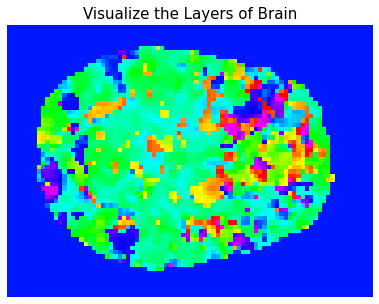

(22, 0)

In [6]:
combined_pipeline_polar = nib.load('combined_pipeline_polar.nii.gz')
combined_pipeline_polar_np = combined_pipeline_polar.get_fdata()
print('combined_pipeline_polar.nii.gz:', combined_pipeline_polar_np.shape)

# Run the ipywidgets interact() function to explore the data
image_data = combined_pipeline_polar_np
interact(explore_4dimage, layer=(0, image_data.shape[2] - 1), channel=(0, image_data.shape[3] - 1), cmap='gist_rainbow');

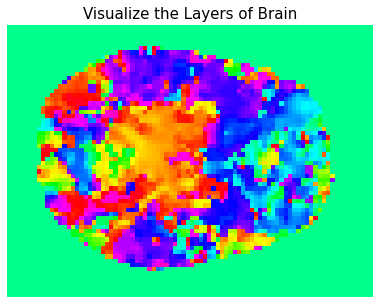

(22, 0)

In [7]:
combined_pipeline_eccentricity = nib.load('combined_pipeline_eccentricity.nii.gz')
combined_pipeline_eccentricity_np = combined_pipeline_eccentricity.get_fdata()
print('combined_pipeline_eccentricity.nii.gz:', combined_pipeline_eccentricity_np.shape)

# Run the ipywidgets interact() function to explore the data
image_data = combined_pipeline_eccentricity_np
interact(explore_4dimage, layer=(0, image_data.shape[2] - 1), channel=(0, image_data.shape[3] - 1), cmap='gist_rainbow');

max values for polar: 359.9690856933594 0.7483667135238647
mean for polar: 233.96848964712274 0.12371902498987869


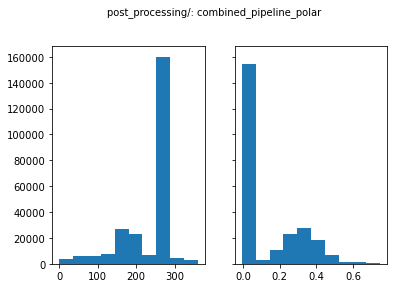

In [8]:
idx_0_polar_nifti = combined_pipeline_polar_np[:,:,:,0].flatten()
idx_1_polar_nifti = combined_pipeline_polar_np[:,:,:,1].flatten()

print('max values for polar:', np.max(idx_0_polar_nifti), np.max(idx_1_polar_nifti)) 
print('mean for polar:', np.mean(idx_0_polar_nifti), np.mean(idx_1_polar_nifti)) 

# Create two subplots
f2, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(idx_0_polar_nifti)
ax2.hist(idx_1_polar_nifti)

# Add text in figure coordinates
plt.figtext(0.5, 1, 'post_processing/: combined_pipeline_polar', ha='center', va='center');

max values for eccentricity: 359.99688720703125 0.7822123765945435
mean for eccentricity: 185.92422944239206 0.1100603480646553


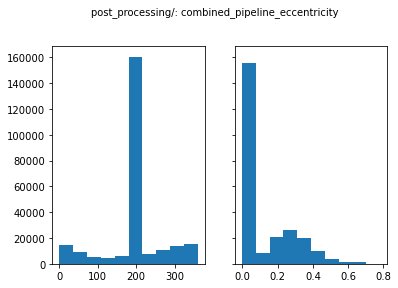

In [9]:
idx_0_eccentricity_nifti = combined_pipeline_eccentricity_np[:,:,:,0].flatten()
idx_1_eccentricity_nifti = combined_pipeline_eccentricity_np[:,:,:,1].flatten()

print('max values for eccentricity:', np.max(idx_0_eccentricity_nifti), np.max(idx_1_eccentricity_nifti)) 
print('mean for eccentricity:', np.mean(idx_0_eccentricity_nifti), np.mean(idx_1_eccentricity_nifti))

# Create two subplots
f3, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(idx_0_eccentricity_nifti)
ax2.hist(idx_1_eccentricity_nifti)

# Add text in figure coordinates
plt.figtext(0.5, 1, 'post_processing/: combined_pipeline_eccentricity', ha='center', va='center');

### # nifti_to_cartesian(polar, eccentricity)
- for post_processing/:

In [10]:
def nifti_to_cartesian(polar, eccentricity):
    
    '''
    
    polar: combined_pipeline_polar_np
    eccentricity: combined_pipeline_eccentricity_np 
    
    '''

    output = np.zeros(polar.shape)
    
    # eccentricity is from 360-0 ??
    data_ecc = np.abs(eccentricity - 360)
#     data_ecc = eccentricity
    
    # make it -0.5 to 0.5 as Lynn's
    # check https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
    data_ecc = 1*((data_ecc - min(data_ecc.flatten())) / (max(data_ecc.flatten()) - min(data_ecc.flatten()))) - 0.5
    
    
    for x in range(polar.shape[0]):
        for y in range(polar.shape[1]):
            for z in range(polar.shape[2]):
            
                theta = polar[x, y, z, 0]
                r = data_ecc[x, y, z, 0]
        
                output[x, y, z, 0] = r * np.cos(theta) # x coordinate
                output[x, y, z, 1] = r * np.sin(theta) # y coordinate 
            
    return output # x and y cartesian coordinates per voxel

In [11]:
# post_processing to cartesian:

post_processing_to_cartesian = nifti_to_cartesian(combined_pipeline_polar_np, combined_pipeline_eccentricity_np)
print('post_processing_to_cartesian', post_processing_to_cartesian.shape)

post_processing_to_cartesian (64, 86, 45, 2)


max values for x and y: 0.4996522894575024 0.4998984170266984
min values for x and y: -0.49969766560801254 -0.4997017819998927
mean for x and y: 7.51598034035789e-05 -3.093162609341855e-05


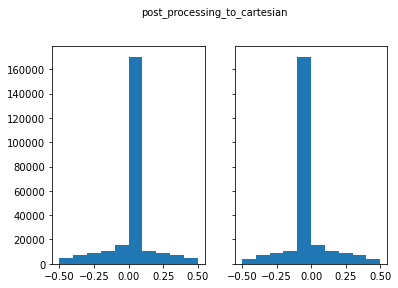

In [19]:
idx_0_cartesian = post_processing_to_cartesian[:,:,:,0].flatten()
idx_1_cartesian = post_processing_to_cartesian[:,:,:,1].flatten()

print('max values for x and y:', np.max(idx_0_cartesian), np.max(idx_1_cartesian)) 
print('min values for x and y:', np.min(idx_0_cartesian), np.min(idx_1_cartesian)) 
print('mean for x and y:', np.mean(idx_0_cartesian), np.mean(idx_1_cartesian))

# Create two subplots and unpack the output array immediately
c2, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(idx_0_cartesian)
ax2.hist(idx_1_cartesian)

# Add text in figure coordinates
plt.figtext(0.5, 1, 'post_processing_to_cartesian', ha='center', va='center');

In [22]:
# All voxels (Not quite sure though about the order ???)
# Check also the next section for VIS 

col_centers_forAll = post_processing_to_cartesian[:,:,:,0].flatten() 
row_centers_forAll = post_processing_to_cartesian[:,:,:,1].flatten()

## # Record cartesian coord. into a Dictonary for VIS

In [23]:
# fusiform face area (FFA)
# occipital face area (OFA)
# parahippocampal place area (PPA)
# extrastriate body area (EBA)
# lateral occipital complex (LOC)
# early visual cortex (VIS)

ROI = 'VIS'

In [25]:
# cartesian coordinates for all voxels
cartesian_forAll = post_processing_to_cartesian # shape: (64, 86, 45, 2)

# mask VIS
os.chdir('/home/soyorh/Desktop/studyforrest/studyforrest-data-visualrois/sub-{}/rois/'.format(subject_id))

try:
    VIS_mask = nib.load('VIS_1_mask.nii.gz').get_fdata()
except:
    print('There is no VIS_1_mask.nii.gz for subject {}'.format(subject_id)) 

try:
    VIS_2_mask = nib.load('VIS_2_mask.nii.gz').get_fdata()
    VIS_mask += VIS_2_mask
except:
    print('There is no VIS_2_mask.nii.gz for subject {}'.format(subject_id))


# Apply the VIS mask 
if os.path.exists('VIS_1_mask.nii.gz'):

    mask_bool = np.array(VIS_mask, dtype=bool) 

    ### ?? not exactly sure which one should be row or column
    col_centers_VIS = cartesian_forAll[:,:,:,0][mask_bool]
    row_centers_VIS = cartesian_forAll[:,:,:,1][mask_bool]

else:
    print('Cartesian coord. are not saved. There is no VIS mask for subject {}'.format(subject_id))        


There is no VIS_2_mask.nii.gz for subject 18


In [26]:
col_centers_VIS.shape, row_centers_VIS.shape

((365,), (365,))

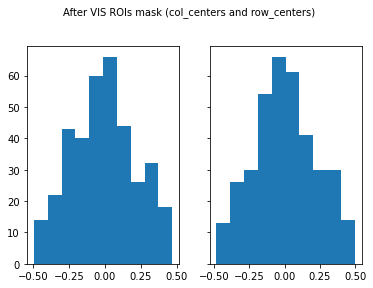

In [27]:
# Create two subplots
l1, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(col_centers_VIS)
ax2.hist(row_centers_VIS)

# Add text in figure coordinates
plt.figtext(0.5, 1, 'After VIS ROIs mask (col_centers and row_centers)', ha='center', va='center');

In [28]:
# most repeated elements

from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

print('most repeated elements/\n', 'column:', most_frequent(col_centers_VIS), 'row:', most_frequent(row_centers_VIS)) 

most repeated elements/
 column: -7.511017765669487e-06 row: 1.3430268374296254e-06


## # Receptive Field Locations for VIS (RFlocations)

### # Functions

In [29]:
# Applying Lynn's code (modified)

def get_RF(col_centers, row_centers, size_x, size_y):
    
    V1_col_nan= col_centers
    V1_col = V1_col_nan[~np.isnan(V1_col_nan)]

    V1_row_nan = row_centers
    V1_row = V1_row_nan[~np.isnan(V1_row_nan)]

    centers = np.stack((V1_col , V1_row))
    
    unitA_x = 1/size_x
    unitA_y = 1/size_y
    channels = np.zeros((len(V1_col), size_x, size_y))

    for elect_i, coord in enumerate(centers.transpose(1,0)):
        channels[elect_i, int((coord[0] + 0.5 ) / unitA_x), int((coord[1] + 0.5 ) / unitA_y)] = 1
    
    fig = plt.figure(frameon=False)
    plt.imshow(channels.sum(0), cmap='Greys_r') 
    plt.title('VIS: Early Visual Cortex')
    plt.axis('off')
    plt.show()
    print(channels.shape)

    return channels

In [30]:
def crop_RF(channels, size):
    
    # part 1
    start_y = (channels.shape[1] - size)//2 - 1
    end_y = channels.shape[1] - (channels.shape[1] - size)//2 - 1
    start_x = (channels.shape[2] - size)//2 - 1
    end_x = (channels.shape[2] - (channels.shape[2] - size)//2) - 1
    
    cropped_channels = channels[:, start_y:end_y, start_x:end_x]
    
    # part 2
    removed_RFs = []
    for idx in range(cropped_channels.shape[0]):
        if np.sum(cropped_channels[idx,:,:]) == 0:
            removed_RFs.append(idx)

    # figure
    fig = plt.figure(frameon=False)
    plt.imshow(cropped_channels.sum(0), cmap='Greys_r') 
    plt.title('VIS: Early Visual Cortex')
    plt.axis('off')
    plt.show()
    print(np.delete(cropped_channels, removed_RFs, axis=0).shape)
    
    return np.delete(cropped_channels, removed_RFs, axis=0), removed_RFs

In [31]:
# see for reference: https://stackoverflow.com/questions/54962004/implement-max-mean-poolingwith-stride-with-numpy

def pool2d(A, kernel_size, stride, padding, pool_mode='max'):
    
    '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    
    from numpy.lib.stride_tricks import as_strided
    
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size)//stride + 1,
                    (A.shape[1] - kernel_size)//stride + 1)
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(A, shape = output_shape + kernel_size, 
                        strides = (stride*A.strides[0],
                                   stride*A.strides[1]) + A.strides)
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(1,2)).reshape(output_shape)
    elif pool_mode == 'avg':
        return A_w.mean(axis=(1,2)).reshape(output_shape)

In [32]:
def downsize_RF(col_centers_VIS, row_centers_VIS, subject_id, crop_size=672, final_size=96, brain_region='VIS'):
    
    RF_forVIS = get_RF(col_centers_VIS, row_centers_VIS, 1024, 1280);
    [RF_cropped, removed_RFs] = crop_RF(RF_forVIS, crop_size)
    
    n = crop_size//final_size
    
    downsized_channels = np.zeros((RF_cropped.shape[0], final_size, final_size))
    for idx in range(RF_cropped.shape[0]):
        downsized_channels[idx, :, :] = pool2d(RF_cropped[idx, :, :],
                                       kernel_size=n, stride=n, padding=0, pool_mode='max')

    fig = plt.figure(frameon=False)
    plt.imshow(downsized_channels.sum(0), cmap='Greys_r') 
    plt.title('VIS: Early Visual Cortex')
    plt.axis('off')
    plt.show()
    print(downsized_channels.shape)
    
    os.makedirs(f'whole_brainfigures/sub-{subject_id}', exist_ok=True)
    fig.savefig(f'whole_brainfigures/sub-{subject_id}/RF_VIS.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)
    
    os.makedirs(f'RF_locations/sub-{subject_id}', exist_ok=True)
    np.save(f'RF_locations/sub-{subject_id}/RFlocs_{brain_region}.npy', downsized_channels)
    
    return downsized_channels.astype('float32')

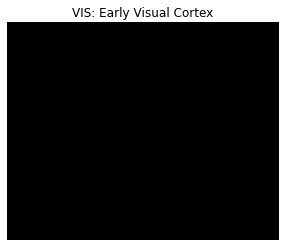

(365, 1024, 1280)


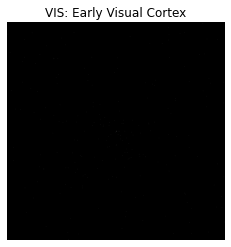

(216, 672, 672)


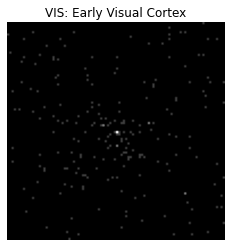

(216, 96, 96)


In [33]:
os.chdir('/home/soyorh/Desktop/studyforrest/Preprocessing steps')

RF_downsized = downsize_RF(col_centers_VIS, row_centers_VIS, '18')

## # Receptive Field Signals for VIS (RFsignals)

### # functions

In [35]:
def crop_RFsignals(allbrain_signal, VIS_mask, col_centers_VIS, row_centers_VIS, size):
    
    RF_forVIS = get_RF(col_centers_VIS, row_centers_VIS, 1024, 1280);
    [RF_cropped, removed_RFs] = crop_RF(RF_forVIS, size)
    
    signals_nan = allbrain_signal[VIS_mask, :]
    signals = signals_nan[~np.isnan(col_centers_VIS), :]
    
    return np.delete(signals, removed_RFs, axis=0)

In [36]:
# Applying Lynn's code (modified)

def save_RFsignals(subject_id, runs, col_centers, row_centers, set_t, crop_size=672, brain_region = 'VIS'):
    
    '''
    subject_id = '18'
    runs = ['1', '2', '3', '4', '5', '6', '7', '8']
    
    '''
    
    for run in tqdm(runs):
          
        print(f'run:{run}')
        
        os.chdir('/huge/soyorh/studyforrest-data-aligned')
        bold_fname = 'sub-{}/in_bold3Tp2/sub-{}_task-avmovie_run-{}_bold.nii.gz'.format(subject_id, subject_id, run)
        allbrain_signal = nib.load(bold_fname).get_fdata()
        
#         if set_t == 'training':
        allbrain_signal_z = stats.zscore(allbrain_signal, 0)
        allbrain_signal_z[np.isnan(allbrain_signal_z)] = 0
        allbrain_signal = allbrain_signal_z

        # ROI
        os.chdir('/home/soyorh/Desktop/studyforrest/Preprocessing steps')
        a_file = open("VIS_mask_perSubject.pkl", "rb")
        VIS_mask = pickle.load(a_file)[subject_id].astype('bool')

        signals = crop_RFsignals(allbrain_signal, VIS_mask, col_centers, row_centers, crop_size)
        print(signals.shape)
        
        os.makedirs(f'{set_t}_signalsRF/sub-{subject_id}/{brain_region}/', exist_ok=True)
        np.save(f'{set_t}_signalsRF/sub-{subject_id}/{brain_region}/{run}_{set_t[:-3]}.npy', signals)

In [37]:
os.chdir('/home/soyorh/Desktop/studyforrest/Preprocessing steps')

subject_id = '18'
runs = ['1', '2', '3', '4', '5', '6', '7', '8']
col_centers = col_centers_VIS
row_centers = row_centers_VIS

  0%|          | 0/8 [00:00<?, ?it/s]

run:1


invalid value encountered in true_divide


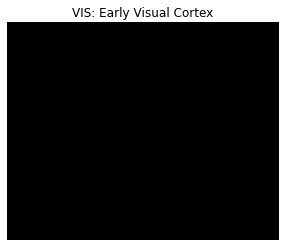

(365, 1024, 1280)


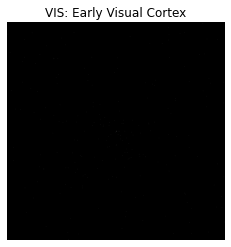

 12%|█▎        | 1/8 [00:06<00:46,  6.71s/it]

(216, 672, 672)
(216, 451)
run:2


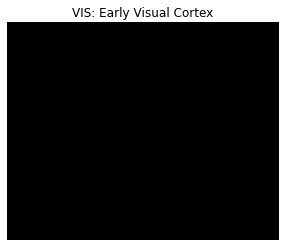

(365, 1024, 1280)


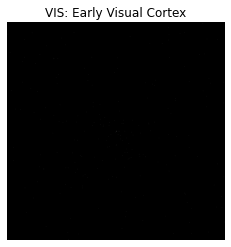

 25%|██▌       | 2/8 [00:12<00:38,  6.37s/it]

(216, 672, 672)
(216, 441)
run:3


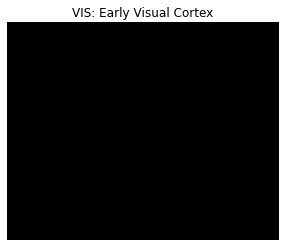

(365, 1024, 1280)


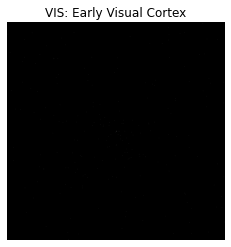

 38%|███▊      | 3/8 [00:18<00:29,  5.94s/it]

(216, 672, 672)
(216, 438)
run:4


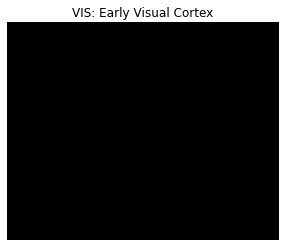

(365, 1024, 1280)


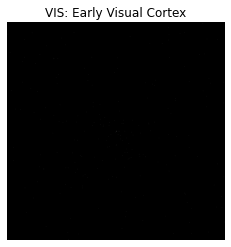

 50%|█████     | 4/8 [00:24<00:24,  6.01s/it]

(216, 672, 672)
(216, 488)
run:5


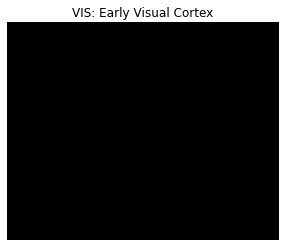

(365, 1024, 1280)


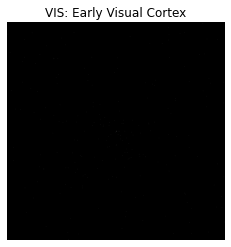

 62%|██████▎   | 5/8 [00:30<00:18,  6.04s/it]

(216, 672, 672)
(216, 462)
run:6


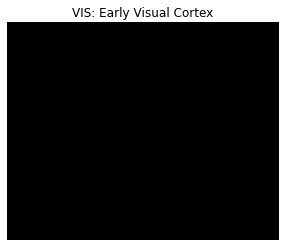

(365, 1024, 1280)


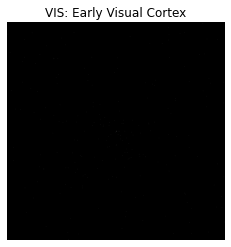

 75%|███████▌  | 6/8 [00:35<00:11,  5.77s/it]

(216, 672, 672)
(216, 439)
run:7


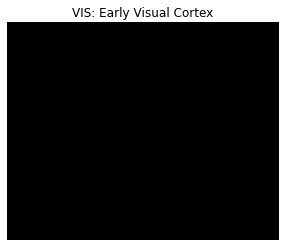

(365, 1024, 1280)


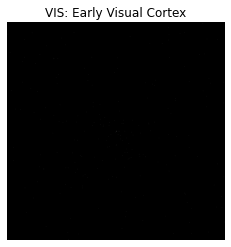

 88%|████████▊ | 7/8 [00:42<00:05,  5.97s/it]

(216, 672, 672)
(216, 542)
run:8


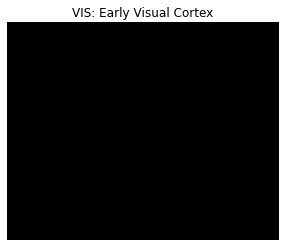

(365, 1024, 1280)


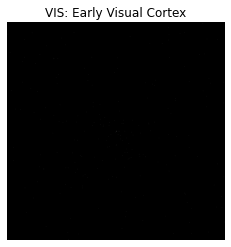

100%|██████████| 8/8 [00:46<00:00,  5.83s/it]

(216, 672, 672)
(216, 338)


In [38]:
save_RFsignals(subject_id, runs, col_centers, row_centers, set_t = 'training')
# invalid value encountered in true_divide stats.zscore 

  0%|          | 0/8 [00:00<?, ?it/s]

run:1


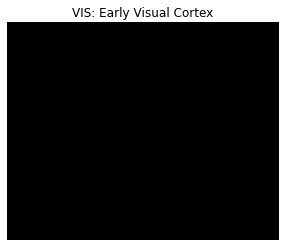

(365, 1024, 1280)


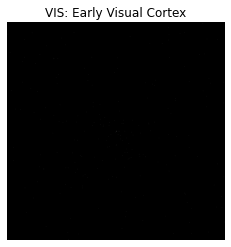

 12%|█▎        | 1/8 [00:05<00:38,  5.43s/it]

(216, 672, 672)
(216, 451)
run:2


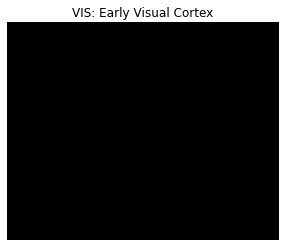

(365, 1024, 1280)


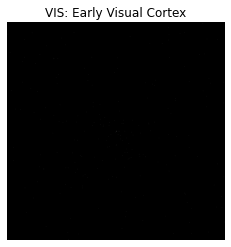

 25%|██▌       | 2/8 [00:10<00:31,  5.30s/it]

(216, 672, 672)
(216, 441)
run:3


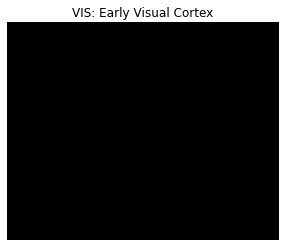

(365, 1024, 1280)


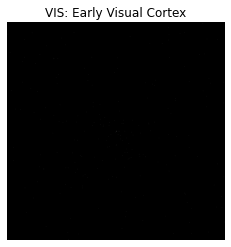

 38%|███▊      | 3/8 [00:16<00:26,  5.34s/it]

(216, 672, 672)
(216, 438)
run:4


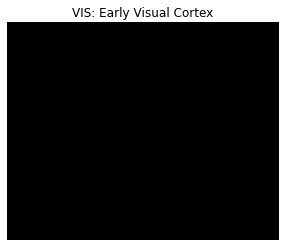

(365, 1024, 1280)


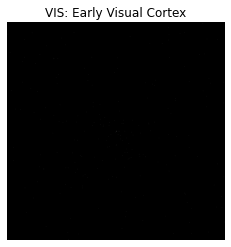

 50%|█████     | 4/8 [00:21<00:22,  5.56s/it]

(216, 672, 672)
(216, 488)
run:5


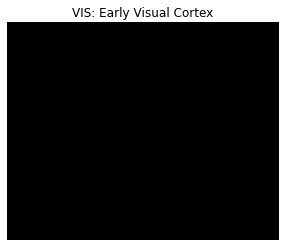

(365, 1024, 1280)


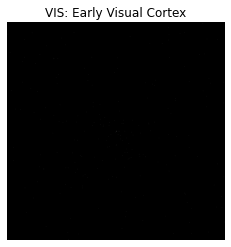

 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

(216, 672, 672)
(216, 462)
run:6


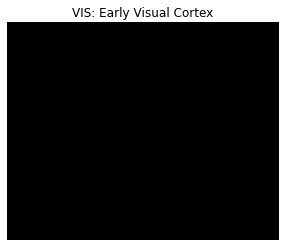

(365, 1024, 1280)


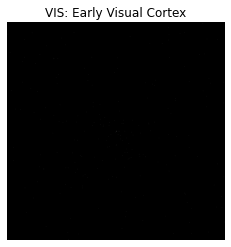

 75%|███████▌  | 6/8 [00:32<00:10,  5.45s/it]

(216, 672, 672)
(216, 439)
run:7


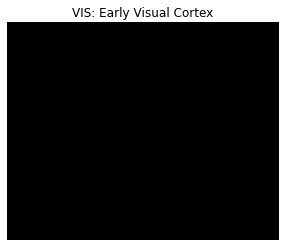

(365, 1024, 1280)


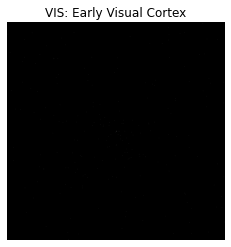

 88%|████████▊ | 7/8 [00:39<00:05,  5.87s/it]

(216, 672, 672)
(216, 542)
run:8


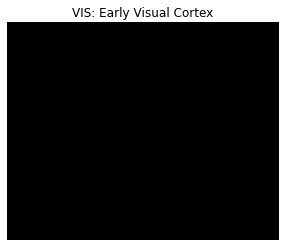

(365, 1024, 1280)


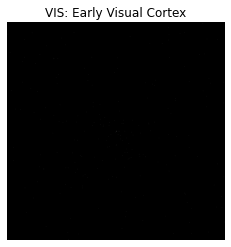

100%|██████████| 8/8 [00:44<00:00,  5.53s/it]

(216, 672, 672)
(216, 338)


In [39]:
save_RFsignals(subject_id, runs, col_centers, row_centers, set_t = 'testing')

### # check the data

In [49]:
set_t = 'training'
subject_id = '18'
brain_region = 'VIS'

os.chdir(f'/home/soyorh/Desktop/studyforrest/Preprocessing steps/{set_t}_signalsRF/sub-{subject_id}/{brain_region}/')

In [50]:
!ls

1_train.npy  3_train.npy  5_train.npy  7_train.npy  all_training_RFsignals.npy
2_train.npy  4_train.npy  6_train.npy  8_train.npy


In [51]:
data = np.load('1_train.npy')
data.shape

(216, 451)

1.2620191764036808

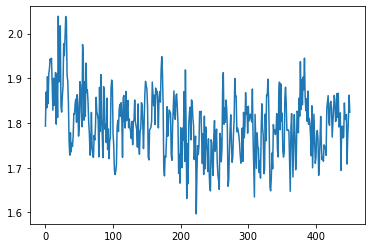

In [54]:
plt.plot(data[100])
np.mean(data)

In [55]:
set_t = 'testing'
subject_id = '18'
brain_region = 'VIS'

os.chdir(f'/home/soyorh/Desktop/studyforrest/Preprocessing steps/{set_t}_signalsRF/sub-{subject_id}/{brain_region}/')

In [56]:
!ls

1_test.npy  3_test.npy	5_test.npy  7_test.npy	all_testing_RFsignals.npy
2_test.npy  4_test.npy	6_test.npy  8_test.npy


In [57]:
data = np.load('1_test.npy')
data.shape

(216, 451)

1.2620191764036808

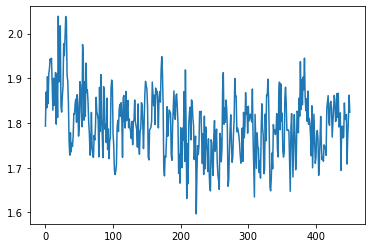

In [58]:
plt.plot(data[100])
np.mean(data)